In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# libraries and tools

In [5]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance  # this is for image preprocessing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # this is for loading images
from tensorflow.keras.models import Sequential  # this is for building the model (note: capital S)
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # this is for model layers (fixed typo)
from tensorflow.keras.optimizers import Adam  # tthis is for optimizer
from tensorflow.keras.applications import VGG16  # this is for using VGG16 model
from sklearn.utils import shuffle  # this is for shuffling the data


# dataset loading


In [ ]:
import os

#train directory count
train_count = sum(
    len(files)
    for _, _, files in os.walk(train_dir)
)

#test directory count
test_count = sum(
    len(files)
    for _, _, files in os.walk(test_dir)
)

print(f"Number of images in training directory: {train_count}")
print(f"Number of images in testing directory:  {test_count}")


In [ ]:
import os
from sklearn.utils import shuffle

#directory paths
train_dir = '/content/drive/MyDrive/testfolder/training'
test_dir  = '/content/drive/MyDrive/testfolder/testing'

#loading and shuffeling of both training and testing data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

#printing of all training and testing paths
print("Training dataset:")
for path, label in zip(train_paths, train_labels):
    print(path, "->", label)


print("\nTesting dataset:")
for path, label in zip(test_paths, test_labels):
    print(path, "->", label)


# data visualisation

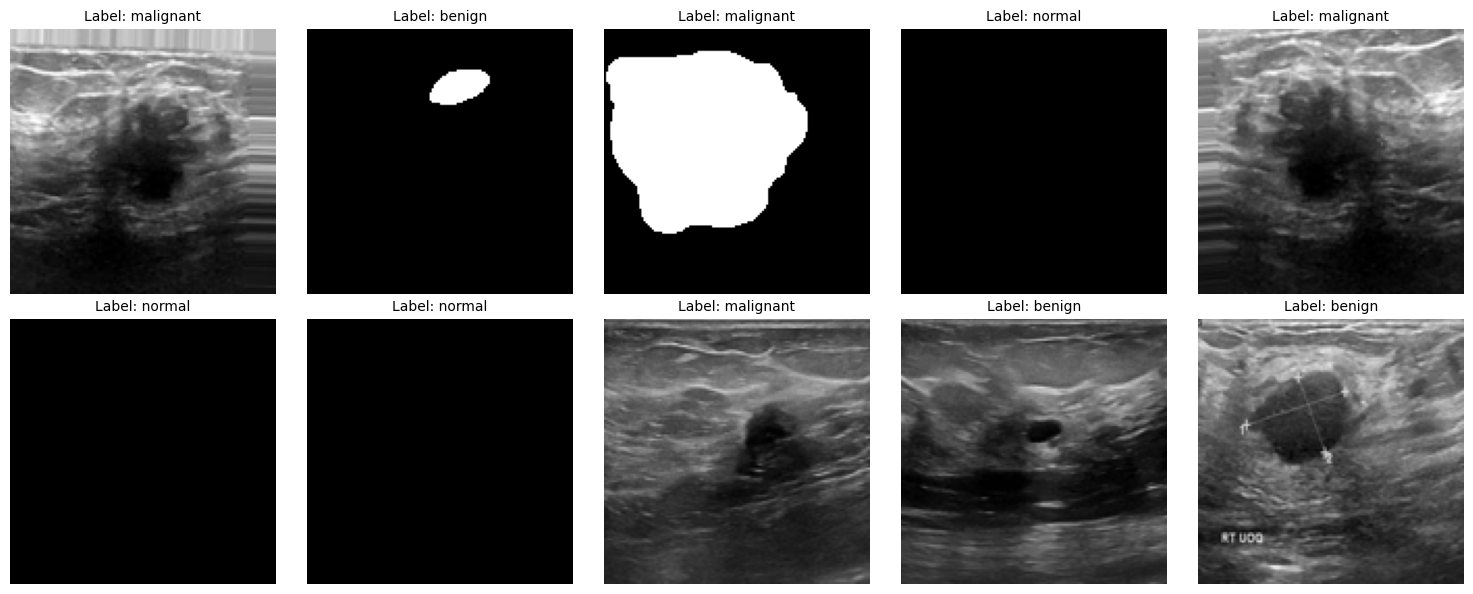

In [8]:
import random
import matplotlib.pyplot as plt
from PIL import Image

#random image sample
random_indices = random.sample(range(len(train_paths)), 10)

#displaying images into rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

# data augmentation **DO NOT EXECUTE**






In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

#paths to the directories
base_dir = '/content/drive/My Drive/testfolder'
benign_dir    = os.path.join(base_dir, 'benign')
malignant_dir = os.path.join(base_dir, 'malignant')
normal_dir    = os.path.join(base_dir, 'normal')

#fixed target size for the model
target_size = (224, 224)

#parametes for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_inplace(folder, target_count):
    originals = [f for f in os.listdir(folder)
                 if f.lower().endswith(('.jpg','.jpeg','.png'))]
    current_count = len(originals)
    print(f"{folder}: {current_count} images now.")
    if current_count == 0:
        print("No images found in", folder)
        return
    if current_count >= target_count:
        print("Already has enough images.")
        return

    n_to_generate = target_count - current_count
    print(f"Need to generate {n_to_generate} new images in {folder}")

    i = 0
    while i < n_to_generate:
        for img_name in originals:
            img_path = os.path.join(folder, img_name)
            img = load_img(img_path, target_size=target_size)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            for _ in datagen.flow(x, batch_size=1,
                                  save_to_dir=folder,
                                  save_prefix='aug',
                                  save_format='jpg'):
                i += 1
                if i >= n_to_generate:
                    break
            if i >= n_to_generate:
                break
    print(f"Done: {folder} now has ~{target_count} images.\n")

#call
augment_inplace(benign_dir, 891)
augment_inplace(malignant_dir, 891)
augment_inplace(normal_dir, 891)



# Image Preprocessing


In [9]:
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

#setting target image size for model
IMAGE_SIZE = 224

def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_to_array(img)
        img = img / 255.0     #normalization of pixel value
        images.append(img)
    return np.array(images)

#Encode labels
def encode_label(labels):
    unique_labels = sorted(os.listdir(train_dir))
    encoded = [unique_labels.index(label) for label in labels]
    return encoded

def datagen(paths, labels, batch_size=12, epochs=1):
    unique_labels = sorted(os.listdir(train_dir))
    num_classes = len(unique_labels)

    for epoch in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i+batch_size]
            batch_labels = encode_label(batch_labels)
            batch_labels = to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels


# **VGG16**



In [ ]:
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#parameters
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 10

#path to the dataset
base_dir = "/content/drive/MyDrive/testfolder"
train_dir = os.path.join(base_dir, "training")
test_dir = os.path.join(base_dir, "testing")

# Rescale images to [0,1]
datagen = ImageDataGenerator(rescale=1./255)

#training and testing data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)


base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                   include_top=False,
                   weights="imagenet")


for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers[-4:]:
    layer.trainable = True


model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))




# vgg16 model save

In [ ]:
model.save("/content/drive/MyDrive/testfolder/vgg16_model.h5")
print("VGG16 model saved successfully!")

# vgg16 model load

In [ ]:
vgg16_model = load_model("/content/drive/MyDrive/vgg16_model.h5")
print("VGG16 model loaded successfully!")

# MODEL REPORT [**vgg16**]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.show()

# 2. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 3. Predictions & Classification Report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_probs = model.predict(test_generator, steps=len(test_generator))

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


# Cohen’s Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

# True labels
y_true = test_generator.classes

# Predictions
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"VGG16 - Cohen's Kappa Score: {kappa:.4f}")



# **DenseNet121**

In [ ]:
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 10

# Path to the dataset
base_dir = "/content/drive/MyDrive/testfolder"
train_dir = os.path.join(base_dir, "training")
test_dir = os.path.join(base_dir, "testing")

# Rescale images to [0,1]
datagen = ImageDataGenerator(rescale=1./255)

# Training and testing data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

# Base model: DenseNet121
base_model = DenseNet121(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze most layers and unfreeze last few for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last ~30 layers (you can adjust)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),           # better than Flatten for DenseNet
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


# DenseNet121 model save


In [ ]:
model.save("/content/drive/MyDrive/testfolder/densenet121_model.h5")
print("DenseNet121 model saved successfully!")


# DenseNet121 model load

In [ ]:
densenet121_model = load_model("/content/drive/MyDrive/densenet121_model.h5")
print("DenseNet121 model loaded successfully!")

# MODEL REPORT [DenseNet121]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('DenseNet121 - Accuracy vs Epochs')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('DenseNet121 - Loss vs Epochs')

plt.show()

# 2. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nDenseNet121 Test Loss: {test_loss:.4f}")
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}")

# 3. Predictions & Classification Report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nDenseNet121 - Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_generator.class_indices.keys())
))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("DenseNet121 - Confusion Matrix")
plt.show()


# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(test_generator.class_indices)
class_names = list(test_generator.class_indices.keys())

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Get predicted probabilities
y_pred_probs = model.predict(test_generator, steps=len(test_generator))

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Diagonal line (random guess)
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DenseNet121 - ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


#Cohen’s Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

#True labels
y_true = test_generator.classes

#Predictions
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

#Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"DenseNet121 - Cohen's Kappa Score: {kappa:.4f}")


# **MobileNetV2**

In [ ]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMAGE_SIZE = 128
BATCH_SIZE = 20
EPOCHS = 10

# Path to the dataset
base_dir = "/content/drive/MyDrive/testfolder"
train_dir = os.path.join(base_dir, "training")
test_dir = os.path.join(base_dir, "testing")

# Rescale images to [0,1]
datagen = ImageDataGenerator(rescale=1./255)

# Training and testing data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

# Base model: MobileNetV2
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze most layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last ~30 layers for fine-tuning (you can adjust this)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation="softmax")
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


# MobileNetV2 model save

In [11]:
model.save("/content/drive/MyDrive/mobilenetv2_model.h5")
print("MobileNetV2 model saved successfully!")

MobileNetV2 model saved successfully!


# MobileNetV2 model load

In [ ]:
mobilenetv2_model = load_model("/content/drive/MyDrive/mobilenetv2_model.h5")
print("MobileNetV2 model loaded successfully!")

# model report [**MobileNetV2**]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNetV2 - Accuracy vs Epochs')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MobileNetV2 - Loss vs Epochs')

plt.show()

# 2. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nMobileNetV2 Test Loss: {test_loss:.4f}")
print(f"MobileNetV2 Test Accuracy: {test_acc:.4f}")

# 3. Predictions & Classification Report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nMobileNetV2 - Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_generator.class_indices.keys())
))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("MobileNetV2 - Confusion Matrix")
plt.show()


# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(test_generator.class_indices)
class_names = list(test_generator.class_indices.keys())

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Get predicted probabilities from MobileNetV2
y_pred_probs = model.predict(test_generator, steps=len(test_generator))

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Diagonal line (random guess)
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MobileNetV2 - ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


# Cohen’s Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

# ✅ True labels
y_true = test_generator.classes

# ✅ Predictions from MobileNetV2
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"MobileNetV2 - Cohen's Kappa Score: {kappa:.4f}")


# **InceptionNetV3**


In [ ]:
import os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
IMAGE_SIZE = 150   # InceptionV3 requires minimum 75x75, better use 150 or 224
BATCH_SIZE = 20
EPOCHS = 10

# Path to the dataset
base_dir = "/content/drive/MyDrive/testfolder"
train_dir = os.path.join(base_dir, "training")
test_dir = os.path.join(base_dir, "testing")

# Rescale images to [0,1]
datagen = ImageDataGenerator(rescale=1./255)

# Training and testing data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

# Base model: InceptionV3
base_model = InceptionV3(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze most layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last ~30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation="softmax")
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


# InceptionNetV3 model save

In [ ]:
model.save("/content/drive/MyDrive/testfolder/inceptionv3_model.h5")
print("InceptionV3 model saved successfully in testfolder!")

# InceptionNetV3 model load

In [ ]:
inceptionv3_model = load_model("/content/drive/MyDrive/inceptionv3_model.keras")
print("InceptionV3 model loaded successfully from .keras format!")

# model report [**InceptionNetV3**]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#1. Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12,5))

#Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('InceptionV3 - Accuracy vs Epochs')

#Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('InceptionV3 - Loss vs Epochs')

plt.show()

#2. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"\nInceptionV3 Test Loss: {test_loss:.4f}")
print(f"InceptionV3 Test Accuracy: {test_acc:.4f}")

#3. Predictions & Classification Report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

#Classification report
print("\nInceptionV3 - Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_generator.class_indices.keys())
))

#4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("InceptionV3 - Confusion Matrix")
plt.show()


# ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

#Number of classes
n_classes = len(test_generator.class_indices)
class_names = list(test_generator.class_indices.keys())

#Binarize the true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Get predicted probabilities from InceptionV3
y_pred_probs = model.predict(test_generator, steps=len(test_generator))

#Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

#Diagonal line (random guess)
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("InceptionV3 - ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


# Cohen’s Kappa Score

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

#True labels
y_true = test_generator.classes

#Predictions from InceptionV3
y_pred_probs = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

#Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"InceptionV3 - Cohen's Kappa Score: {kappa:.4f}")


# **model comparison**

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score


#Parameters
BATCH_SIZE = 20
base_dir = "/content/drive/MyDrive/testfolder"
test_dir = os.path.join(base_dir, "testing")

#For models trained on 128x128 (VGG16, DenseNet121, MobileNetV2)
datagen128 = ImageDataGenerator(rescale=1./255)
test_generator_128 = datagen128.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

#For models trained on 150x150 (InceptionV3)
datagen150 = ImageDataGenerator(rescale=1./255)
test_generator_150 = datagen150.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

#Load Models (update paths as per your Drive)
vgg16_model = load_model("/content/drive/MyDrive/testfolder/vgg16_model.h5")
densenet_model = load_model("/content/drive/MyDrive/testfolder/densenet121_model.h5")
mobilenet_model = load_model("/content/drive/MyDrive/testfolder/mobilenetv2_model.h5")
inception_model = load_model("/content/drive/MyDrive/testfolder/inceptionv3_model.h5")

print(" All models loaded successfully!")

#Evaluation Function
def evaluate_model(model, model_name, test_generator, results):
    print(f"\n Evaluating {model_name}...")
    start_time = time.time()

    #Evaluate
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=0)

    #Predictions
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    #Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    #Classification Report (optional print)
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    #Save results
    runtime = time.time() - start_time
    results.append([model_name, test_loss, test_acc, kappa, runtime])

#Run Evaluation for All Models
results = []
evaluate_model(vgg16_model, "VGG16", test_generator_128, results)
evaluate_model(densenet_model, "DenseNet121", test_generator_128, results)
evaluate_model(mobilenet_model, "MobileNetV2", test_generator_128, results)
evaluate_model(inception_model, "InceptionV3", test_generator_150, results)

#Summary Table
df_results = pd.DataFrame(results, columns=["Model", "Test Loss", "Test Accuracy", "Cohen's Kappa", "Runtime (s)"])
print("\n✅ Model Comparison Summary:\n")
print(df_results)

#Plot Comparison
plt.figure(figsize=(10,6))

x = np.arange(len(df_results["Model"]))

plt.bar(x - 0.2, df_results["Test Accuracy"], width=0.2, label="Accuracy")
plt.bar(x, df_results["Cohen's Kappa"], width=0.2, label="Kappa")
plt.bar(x + 0.2, df_results["Runtime (s)"]/max(df_results["Runtime (s)"]), width=0.2, label="Runtime (scaled)")

plt.xticks(x, df_results["Model"])
plt.ylabel("Scores")
plt.title("Model Comparison: Accuracy, Kappa & Runtime")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

#Convert results into DataFrame with correct column names
df_results = pd.DataFrame(results, columns=["Model", "Test Loss", "Test Accuracy", "Cohen Kappa", "Time (s)"])

#Print summary table
print("\n Model Comparison Table:")
print(df_results)

#Plot Comparison Graphs
metrics = ["Test Accuracy", "Test Loss", "Cohen Kappa"]

plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.bar(df_results["Model"], df_results[metric], color=['skyblue','lightgreen','salmon','orange'])
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylabel(metric)

plt.suptitle("Model Comparison (VGG16, DenseNet121, MobileNetV2, InceptionV3)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

models = ["VGG16", "DenseNet121", "MobileNetV2", "InceptionV3"]
val_acc = [0.9206, 0.9301, 0.8696, 0.9414]

plt.figure(figsize=(8,6))
plt.bar(models, val_acc, color=['skyblue','lightgreen','salmon','orange'])
plt.title("Validation Accuracy Comparison")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1.0)
plt.show()




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Paths & Input Sizes
model_configs = {
    "VGG16": {
        "path": "/content/drive/MyDrive/testfolder/vgg16_model.h5",
        "input_size": (128, 128)
    },
    "DenseNet121": {
        "path": "/content/drive/MyDrive/testfolder/densenet121_model.h5",
        "input_size": (128, 128)
    },
    "MobileNetV2": {
        "path": "/content/drive/MyDrive/testfolder/mobilenetv2_model.h5",
        "input_size": (128, 128)
    },
    "InceptionV3": {
        "path": "/content/drive/MyDrive/testfolder/inceptionv3_model.h5",
        "input_size": (150, 150)
    }
}

# Load Models
loaded_models = {}
for name, cfg in model_configs.items():
    try:
        loaded_models[name] = load_model(cfg["path"])
        print(f"{name} loaded successfully")
    except Exception as e:
        print(f"Could not load {name}\n   Error: {e}")

# Evaluation Function
def evaluate_model(model, model_name, input_size, results):
    print(f"\n Evaluating {model_name}...")


    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        "/content/drive/MyDrive/testfolder/testing", 
        target_size=input_size,
        batch_size=32,
        class_mode="sparse",
        shuffle=False
    )

    #True labels
    y_true = test_generator.classes

    #Predictions
    y_pred_probs = model.predict(test_generator, steps=len(test_generator))
    y_pred = np.argmax(y_pred_probs, axis=1)

    #Metrics
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(
        pd.get_dummies(y_true),
        y_pred_probs,
        multi_class="ovr"
    )
    loss = model.evaluate(test_generator, steps=len(test_generator), verbose=0)[0]

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Kappa": kappa,
        "AUC": auc,
        "Loss": loss
    })

    print(f" {model_name} Results -> Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, AUC: {auc:.4f}, Loss: {loss:.4f}")

# Run Evaluation
results = []
for name, model in loaded_models.items():
    if model is not None:
        evaluate_model(model, name, model_configs[name]["input_size"], results)


# Results Table
df_results = pd.DataFrame(results)
print("\n Model Comparison Table:")
print(df_results)

# Comparison Graph
metrics = ["Accuracy", "Kappa", "AUC"]

plt.figure(figsize=(12, 5))
for metric in metrics:
    plt.plot(df_results["Model"], df_results[metric], marker='o', label=metric)

plt.title("Model Comparison Across Metrics")
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()
